# Optuna framework for pyJedAI fine-tunning

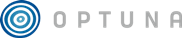



In [35]:
import plotly.express as px
import logging
import sys
import optuna
import plotly
import os
import sys
import pandas as pd
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
from optuna.visualization import *

import plotly.io as pio
import plotly.express as px

pio.templates.default = "plotly_white"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data Reading

In [8]:
from pyjedai.datamodel import Data

data = Data(
    dataset_1=pd.read_csv("./data/D2/abt.csv", sep='|', engine='python', na_filter=False).astype(str),
    attributes_1=['id','name','description'],
    id_column_name_1='id',
    dataset_2=pd.read_csv("./data/D2/buy.csv", sep='|', engine='python', na_filter=False).astype(str),
    attributes_2=['id','name','description'],
    id_column_name_2='id',
    ground_truth=pd.read_csv("./data/D2/gt.csv", sep='|', engine='python'),
)

data.process()

## WorkFlow

In [11]:
from pyjedai.workflow import WorkFlow, compare_workflows
from pyjedai.block_building import StandardBlocking, QGramsBlocking, ExtendedQGramsBlocking, SuffixArraysBlocking, ExtendedSuffixArraysBlocking
from pyjedai.block_cleaning import BlockFiltering, BlockPurging
from pyjedai.comparison_cleaning import WeightedEdgePruning, WeightedNodePruning, CardinalityEdgePruning, CardinalityNodePruning, BLAST, ReciprocalCardinalityNodePruning, ReciprocalWeightedNodePruning, ComparisonPropagation
from pyjedai.matching import EntityMatching
from pyjedai.clustering import ConnectedComponentsClustering

In [12]:
db_name = "pyjedai"
title = "Test"
storage_name = "sqlite:///{}.db".format(db_name)
study_name = title  # Unique identifier of the study.

In [20]:
'''
 OPTUNA objective function
'''
def objective(trial):
    
    w = WorkFlow(
        block_building = dict(
            method=QGramsBlocking, 
            params=dict(qgrams=trial.suggest_int("qgrams", 3, 10)),
            attributes_1=['name'],
            attributes_2=['name']
        ),
        block_cleaning = [
            dict(
                method=BlockPurging,
                params=dict(smoothing_factor=1.025)
            ),
            dict(
                method=BlockFiltering, 
                params=dict(
                    ratio = trial.suggest_float("ratio", 0.7, 0.95)
                )
            )
        ],
        comparison_cleaning = dict(method=CardinalityEdgePruning),
            entity_matching = dict(
            method=EntityMatching, 
            metric='sorensen_dice',
            similarity_threshold= trial.suggest_float("similarity_threshold", 0.05, 0.9),
            attributes = ['description', 'name']
        ),
        clustering = dict(method=ConnectedComponentsClustering),
        name="Worflow-Test"
    )
    w.run(data, tqdm_disable=True, verbose=False)
    f1, precision, recall = w.get_final_scores()
    
    return recall

In [48]:
study_name = title  # Unique identifier of the study.
num_of_trials = 30
study = optuna.create_study(
    directions=["maximize"],
    study_name=study_name,
    storage=storage_name,
    load_if_exists=True
)
print("Optuna trials starting")
study.optimize(
    objective, 
    n_trials=num_of_trials, 
    show_progress_bar=True
)
print("Optuna trials finished")

[I 2022-09-14 17:09:13,506] Using an existing study with name 'Test' instead of creating a new one.


Optuna trials starting


C:\Users\nikol\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\progress_bar.py:49: ExperimentalWarning:

Progress bar is experimental (supported from v1.2.0). The interface can change in the future.



  0%|          | 0/30 [00:00<?, ?it/s]

[I 2022-09-14 17:09:30,944] Trial 3 finished with value: 99.81412639405205 and parameters: {'qgrams': 3, 'ratio': 0.9417007589580898, 'similarity_threshold': 0.30170985876615275}. Best is trial 3 with value: 99.81412639405205.
[I 2022-09-14 17:09:36,111] Trial 4 finished with value: 94.9814126394052 and parameters: {'qgrams': 8, 'ratio': 0.9383409520444309, 'similarity_threshold': 0.3645506183559789}. Best is trial 3 with value: 99.81412639405205.
[I 2022-09-14 17:09:40,187] Trial 5 finished with value: 92.56505576208178 and parameters: {'qgrams': 10, 'ratio': 0.8771013518732889, 'similarity_threshold': 0.1563462534098541}. Best is trial 3 with value: 99.81412639405205.
[I 2022-09-14 17:09:44,330] Trial 6 finished with value: 93.02973977695167 and parameters: {'qgrams': 9, 'ratio': 0.8487091500829508, 'similarity_threshold': 0.36513366894517046}. Best is trial 3 with value: 99.81412639405205.
[I 2022-09-14 17:09:50,232] Trial 7 finished with value: 98.69888475836431 and parameters: {'q

# Optuna Visualizations

In [49]:
study.trials_dataframe(attrs=("number", "value", "params", "state"))

,number,value,params_qgrams,params_ratio,params_similarity_threshold,state
0,0,92.379182,10,0.821263,0.737996,COMPLETE
1,1,99.628253,5,0.824285,0.466374,COMPLETE
2,2,91.542751,10,0.777054,0.245991,COMPLETE
3,3,99.814126,3,0.941701,0.301710,COMPLETE
4,4,94.981413,8,0.938341,0.364551,COMPLETE
5,5,92.565056,10,0.877101,0.156346,COMPLETE
6,6,93.029740,9,0.848709,0.365134,COMPLETE
7,7,98.698885,6,0.748652,0.057590,COMPLETE
8,8,100.000000,4,0.783864,0.590740,COMPLETE
9,9,99.535316,5,0.732026,0.855720,COMPLETE


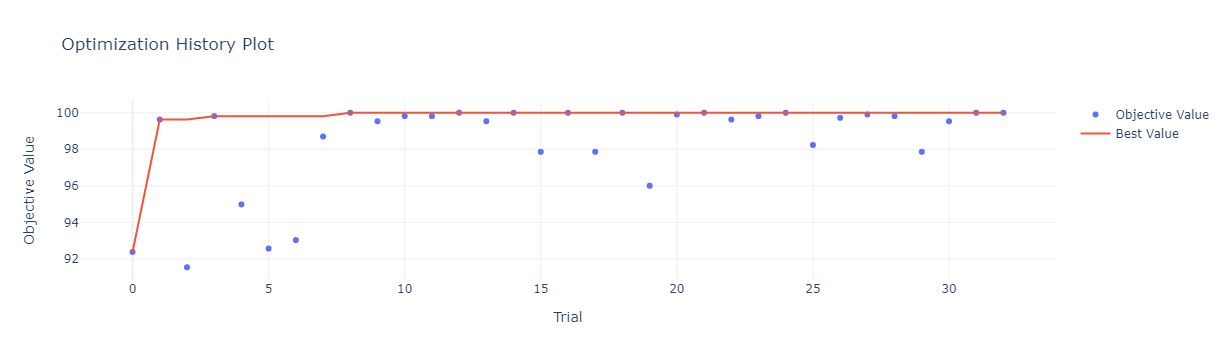

In [50]:
fig = plot_optimization_history(study)
fig.show()

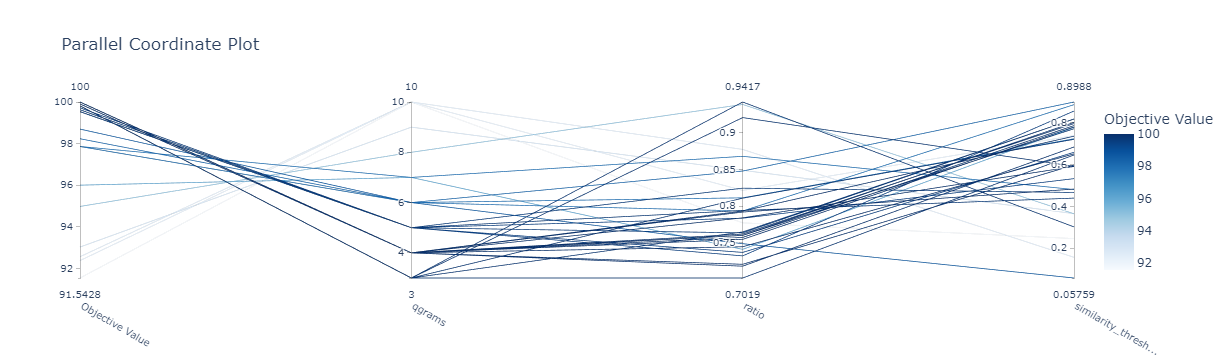

In [51]:
fig = plot_parallel_coordinate(study)
fig.show()

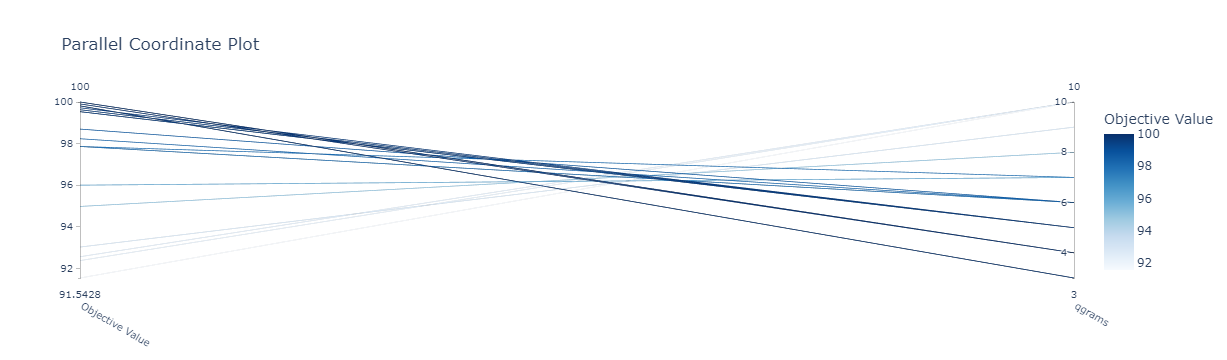

In [52]:
fig = plot_parallel_coordinate(study, params=["qgrams"])
fig.show()

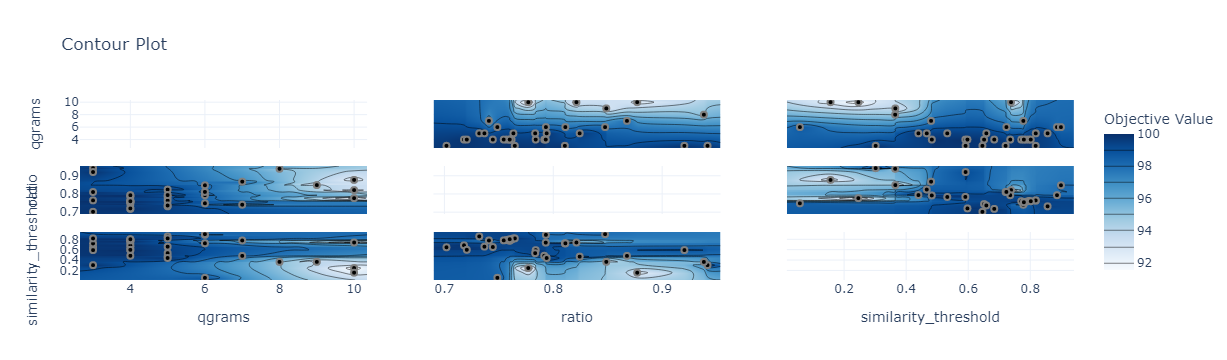

In [53]:
fig = plot_contour(study)
fig.show()

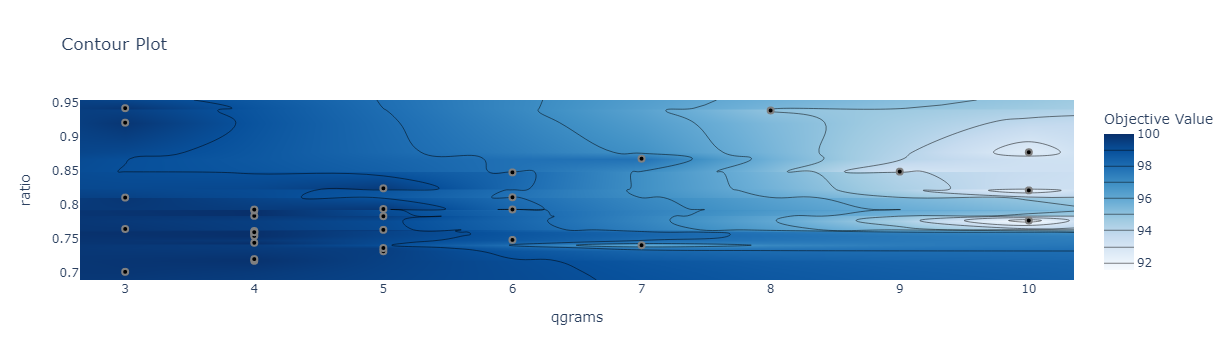

In [54]:
fig = plot_contour(study, params=["qgrams", "ratio"])
fig.show()

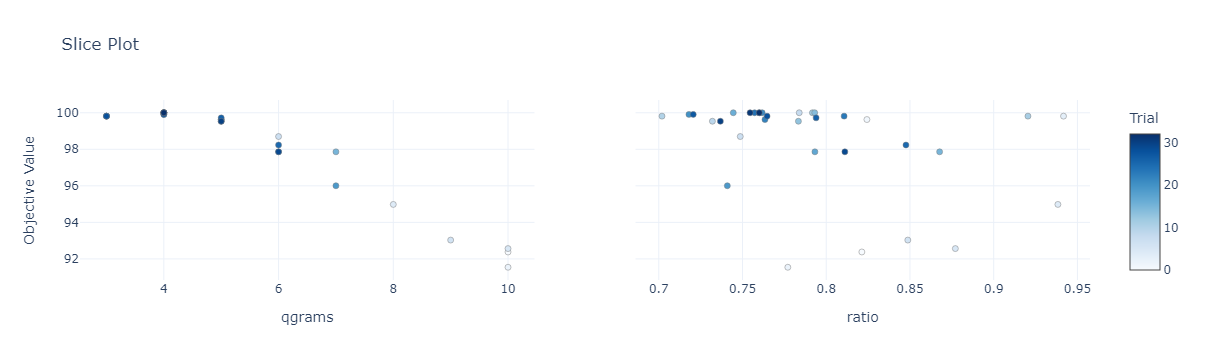

In [55]:
fig = plot_slice(study,  params=["qgrams", "ratio"])
fig.show()

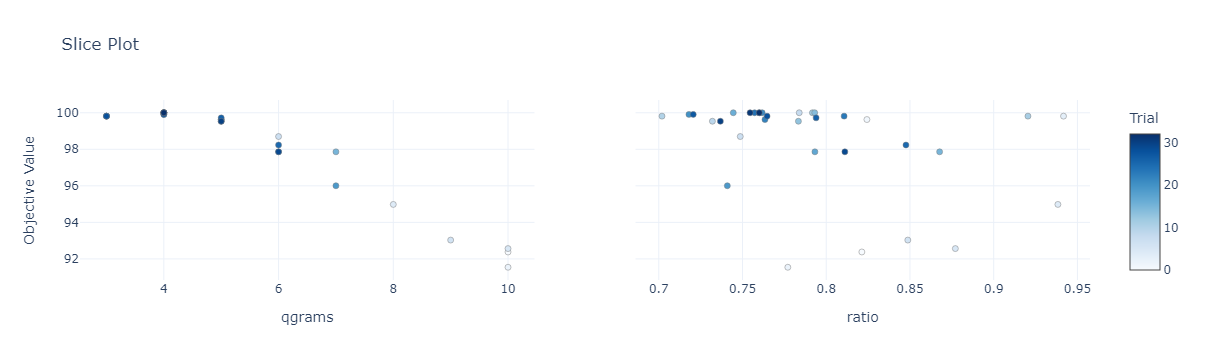

In [56]:
fig = plot_slice(study,  params=["qgrams", "ratio"])
fig.show()

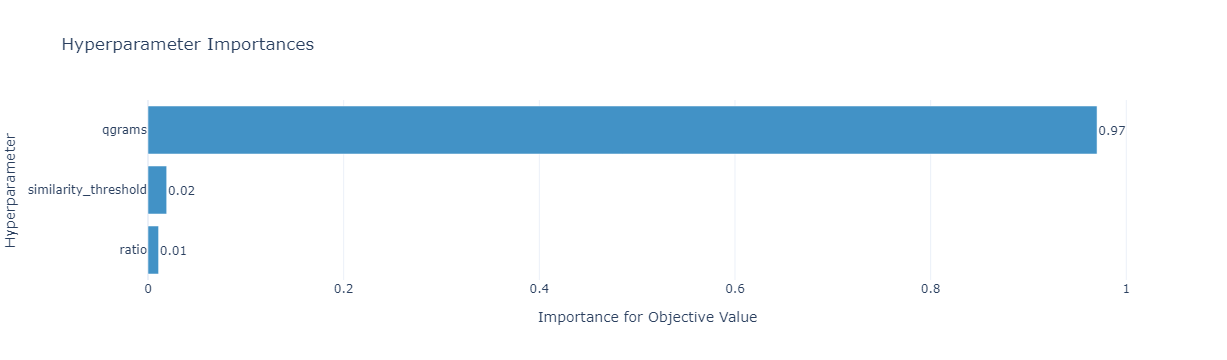

In [57]:
fig = plot_param_importances(study)
fig.show()

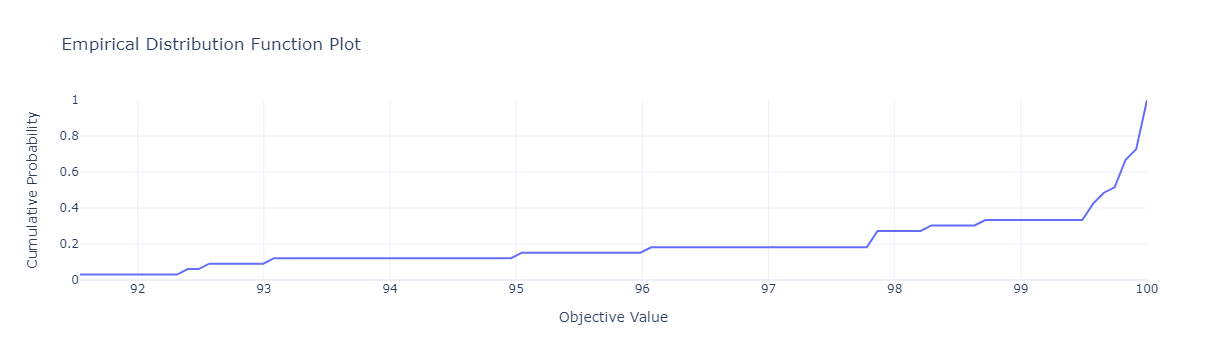

In [58]:
fig = plot_edf(study)
fig.show()

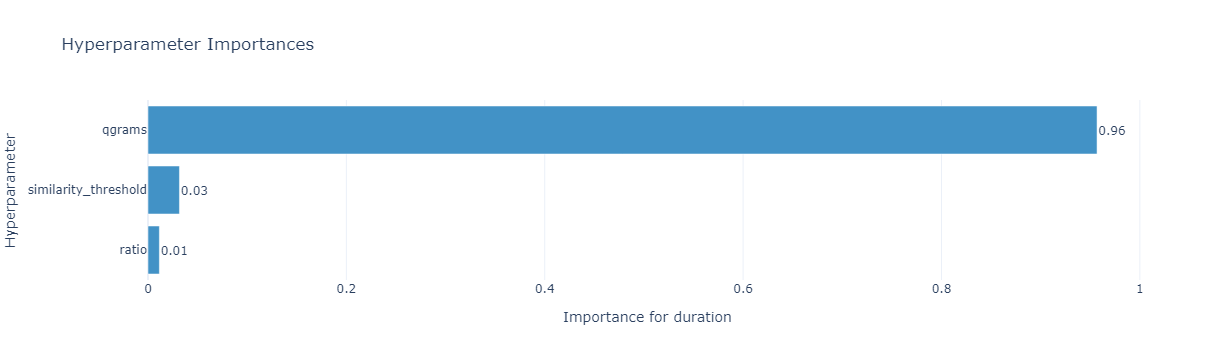

In [59]:
fig = optuna.visualization.plot_param_importances(
    study, target=lambda t: t.duration.total_seconds(), target_name="duration"
)
fig.show()